In [2]:
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import networkx as nx
import pandas as pd
import geopandas as gpd

%matplotlib inline

ox.config(log_console=True, use_cache=True)
weight_by_length = False

ox.__version__

'0.15.1'

In [5]:
point = (38.247544, -85.755769)
G = ox.graph_from_point(point, dist = 50000, network_type='drive')

In [6]:
path = '/Users/andrewrenninger/Desktop/R/git/jams/data/'
os.chdir(path)

In [10]:
ox.io.save_graph_shapefile(G, "test")

In [15]:
data = pd.read_csv("https://raw.githubusercontent.com/asrenninger/jams/master/data/blocks.csv")

data.head()

,id,geocode_h,geocode_w,X_h,Y_h,X_w,Y_w,jobs
0,211110056001 to 211110012002,211110056001,211110012002,-85.762145,38.175592,-85.813807,38.237289,13
1,211110002003 to 211110024002,211110002003,211110024002,-85.780362,38.276752,-85.779208,38.252533,12
2,210290211022 to 211110027001,210290211022,211110027001,-85.598993,37.947284,-85.775154,38.238981,11
3,211110003001 to 211110027001,211110003001,211110027001,-85.798473,38.265652,-85.775154,38.238981,11
4,211110004004 to 211110027001,211110004004,211110027001,-85.821200,38.266329,-85.775154,38.238981,15


In [19]:
origin = (data.Y_h[-1], data.X_h[-1]) 
destin = (data.Y_w[-1], data.X_w[-1]) 

origin_node = ox.get_nearest_node(G, origin)
destin_node = ox.get_nearest_node(G, destin)

route = nx.shortest_path(G, origin_node, destin_node)

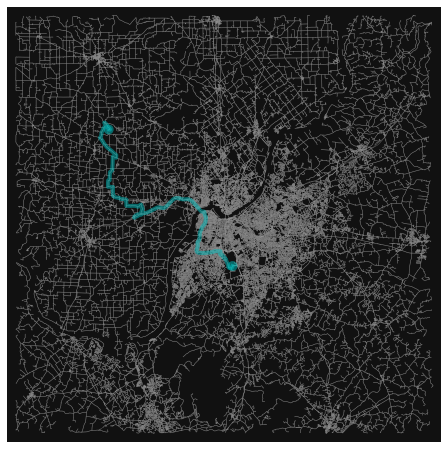

In [142]:
fig, ax = ox.plot_graph_route(G, route, route_color='c', node_size=0, 
                              edge_linewidth = 0.5, edge_alpha = 0.5)

In [124]:
routes = []
misses = []

for i in np.arange(0, data.shape[0]):
    
    origin = (data.Y_h[i], data.X_h[i]) 
    destin = (data.Y_w[i], data.X_w[i]) 

    origin_node = ox.get_nearest_node(G, origin)
    destin_node = ox.get_nearest_node(G, destin)

    try:
        route = nx.shortest_path(G, origin_node, destin_node)
        routes.append(route)
    except:
        misses.append(i)
        

In [145]:
hwy_speeds = {'residential': 35,
              'secondary': 50,
              'tertiary': 60}

G = ox.add_edge_speeds(G, hwy_speeds)
G = ox.add_edge_travel_times(G)

In [158]:
origin = (data.Y_h[500], data.X_h[500]) 
destin = (data.Y_w[500], data.X_w[500]) 

origin_node = ox.get_nearest_node(G, origin)
destin_node = ox.get_nearest_node(G, destin)

direct = nx.shortest_path(G, origin_node, destin_node, weight='length')
faster = nx.shortest_path(G, origin_node, destin_node, weight='travel_time')

In [159]:
direct_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, direct, 'length')))
faster_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, faster, 'length')))

direct_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, direct, 'travel_time')))
faster_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, faster, 'travel_time')))

print('Route 1 is', route1_length, 'meters and takes', direct_time, 'seconds.')
print('Route 2 is', route2_length, 'meters and takes', faster_time, 'seconds.')

Route 1 is 3112 meters and takes 1165 seconds.
Route 2 is 49653 meters and takes 1054 seconds.


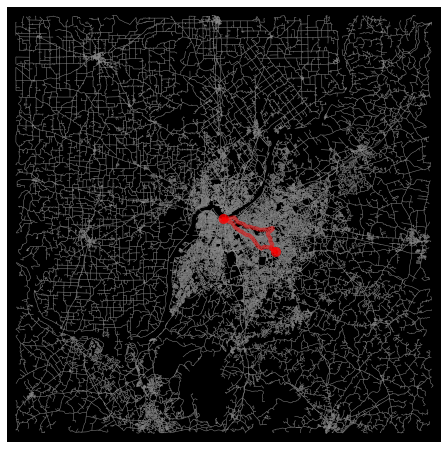

In [176]:
c1 = 'r'
c2 = 'b'

rc1 = [c1] * (len(direct) - 1)
rc2 = [c2] * (len(faster) - 1)

rc = rc1 + rc2

fig, ax = ox.plot_graph_routes(G, [direct, faster], route_color=rc, route_linewidth=4, node_size=0, bgcolor='k',
                               edge_linewidth = 0.5, edge_alpha = 0.5)

In [301]:
geo = gpd.GeoDataFrame()

for i in np.arange(0, np.asarray(routes).shape[0]):
    inf = ox.utils_graph.get_route_edge_attributes(G, routes[i])

    gdf = gpd.GeoDataFrame(inf) 
    gdf = gdf[~gdf.geometry.isna()]
    gdf['dissolve'] = 1

    gdf = gdf.dissolve(by='dissolve', aggfunc='sum')
    gdf = gdf[['geometry', 'length']]
    
    geo = geo.append(gdf)

In [302]:
final = data.drop(misses)

In [303]:
print(final.shape)
print(geo.shape)

(6052, 8)
(6052, 2)


In [310]:
final = pd.concat([geo.reset_index(drop=True), final.reset_index(drop=True)], axis=1)
final.head()

,geometry,length,id,geocode_h,geocode_w,X_h,Y_h,X_w,Y_w,jobs
0,"MULTILINESTRING ((-85.76333 38.17664, -85.7639...",13889.634,211110056001 to 211110012002,211110056001,211110012002,-85.762145,38.175592,-85.813807,38.237289,13
1,"MULTILINESTRING ((-85.78361 38.27251, -85.7836...",5338.452,211110002003 to 211110024002,211110002003,211110024002,-85.780362,38.276752,-85.779208,38.252533,12
2,"MULTILINESTRING ((-85.59848 37.95173, -85.5982...",55361.063,210290211022 to 211110027001,210290211022,211110027001,-85.598993,37.947284,-85.775154,38.238981,11
3,"MULTILINESTRING ((-85.79861 38.26548, -85.7979...",6318.491,211110003001 to 211110027001,211110003001,211110027001,-85.798473,38.265652,-85.775154,38.238981,11
4,"MULTILINESTRING ((-85.82168 38.26602, -85.8216...",9647.355,211110004004 to 211110027001,211110004004,211110027001,-85.821200,38.266329,-85.775154,38.238981,15


In [311]:
final.to_file("imputed_paths.shp")

In [343]:
routes = []
misses = []

for i in np.arange(0, data.shape[0]):
    
    origin = (data.Y_h[i], data.X_h[i]) 
    destin = (data.Y_w[i], data.X_w[i]) 

    origin_node = ox.get_nearest_node(G, origin)
    destin_node = ox.get_nearest_node(G, destin)

    try:
        route = nx.shortest_path(G, origin_node, destin_node, weight='travel_time')
        routes.append(route)
    except:
        misses.append(i)

In [344]:
geo = gpd.GeoDataFrame()

for i in np.arange(0, np.asarray(routes).shape[0]):
    inf = ox.utils_graph.get_route_edge_attributes(G, routes[i])

    gdf = gpd.GeoDataFrame(inf) 
    gdf = gdf[~gdf.geometry.isna()]
    gdf['dissolve'] = 1

    gdf = gdf.dissolve(by='dissolve', aggfunc='sum')
    gdf = gdf[['geometry', 'length']]
    
    geo = geo.append(gdf)

In [345]:
final = data.drop(misses)

In [346]:
print(final.shape)
print(geo.shape)

(6052, 8)
(6052, 2)


In [347]:
final = pd.concat([geo.reset_index(drop=True), final.reset_index(drop=True)], axis=1)
final.head()

,geometry,length,id,geocode_h,geocode_w,X_h,Y_h,X_w,Y_w,jobs
0,"MULTILINESTRING ((-85.76077 38.17554, -85.7609...",14182.049,211110056001 to 211110012002,211110056001,211110012002,-85.762145,38.175592,-85.813807,38.237289,13
1,"MULTILINESTRING ((-85.78361 38.27251, -85.7836...",3810.676,211110002003 to 211110024002,211110002003,211110024002,-85.780362,38.276752,-85.779208,38.252533,12
2,"MULTILINESTRING ((-85.59848 37.95173, -85.5989...",42597.033,210290211022 to 211110027001,210290211022,211110027001,-85.598993,37.947284,-85.775154,38.238981,11
3,"MULTILINESTRING ((-85.79861 38.26548, -85.7986...",5335.482,211110003001 to 211110027001,211110003001,211110027001,-85.798473,38.265652,-85.775154,38.238981,11
4,"MULTILINESTRING ((-85.82168 38.26602, -85.8217...",6911.860,211110004004 to 211110027001,211110004004,211110027001,-85.821200,38.266329,-85.775154,38.238981,15


In [348]:
final.to_file("imputed_roads.shp")

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/asrenninger/jams/master/data/dots.csv")

data.head()

,id,X_h,Y_h,X_w,Y_w
0,211110056001 to 211110012002,-85.763412,38.175549,-85.817122,38.241705
1,211110056001 to 211110012002,-85.761810,38.175646,-85.817587,38.241787
2,211110056001 to 211110012002,-85.760664,38.176049,-85.811635,38.239548
3,211110056001 to 211110012002,-85.762019,38.176387,-85.815233,38.243377
4,211110056001 to 211110012002,-85.760691,38.176792,-85.817830,38.234929


In [7]:
routes = []
misses = []

for i in np.arange(0, data.shape[0]):
    
    origin = (data.Y_h[i], data.X_h[i]) 
    destin = (data.Y_w[i], data.X_w[i]) 

    origin_node = ox.get_nearest_node(G, origin)
    destin_node = ox.get_nearest_node(G, destin)

    try:
        route = nx.shortest_path(G, origin_node, destin_node, weight='travel_time')
        routes.append(route)
    except:
        misses.append(i)

In [8]:
misses_new = []

geo = gpd.GeoDataFrame()

for i in np.arange(0, np.asarray(routes).shape[0]):
    inf = ox.utils_graph.get_route_edge_attributes(G, routes[i])

    try: 
        gdf = gpd.GeoDataFrame(inf) 
        gdf = gdf[~gdf.geometry.isna()]
        gdf['dissolve'] = 1
        
        gdf = gdf.dissolve(by='dissolve', aggfunc='sum')
        gdf = gdf[['geometry', 'length']]
        
        geo = geo.append(gdf)
    except: 
        misses_new.append(i)

In [15]:
print(geo.shape)

(74753, 2)


In [14]:
geo.to_file("imputed_homes_nometa.shp")

In [10]:
final = data.drop(misses)
final = data.drop(misses_new)

In [12]:
print(final.shape)
print(geo.shape)

(74926, 5)
(74753, 2)


In [ ]:
final = pd.concat([geo.reset_index(drop=True), final.reset_index(drop=True)], axis=1)
final.head()

In [ ]:
final.to_file("imputed_homes.shp")